# Entry Point Notebook

This notebook serves as the entry point for the **Crash Course to REINFORCE** project. It demonstrates how to set up the environment, train the REINFORCE agent, evaluate its performance, and visualize the results. 

For deeper exploration see `Baselines.ipynb` and `Reinforece.ipynb`.

---

## Environment Description

This description encapsulates the key elements of the Highway environment. It explains how the various action spaces, controllers, state spaces, reward mechanisms, and observation modalities interact to create a complex, dynamic simulation. By referring to the formulas and explanations provided here, you can ensure that your agent configurations are well-informed and that the environment’s behavior is thoroughly documented.

### Action Spaces

The environment supports three distinct action spaces, allowing different levels of control abstraction:

- **Continuous Action Space:**  
  - **Acceleration ($a$):** The agent outputs a continuous acceleration in the range $[-5.0,\, 5.0]$ m/s².  
  - **Wheel Angle ($\delta$):** The agent outputs a continuous steering command (front wheel angle) in the range $\left[-\frac{\pi}{4},\,\frac{\pi}{4}\right]$ radians.  
  These actions are directly applied to the ego-vehicle’s kinematics (using the bicycle model) after clipping to the valid ranges.

- **Discrete Action Space:**  
  This is a quantized version of the continuous action space. By default, each continuous value is discretized into 3 levels. This space is useful when one wishes to restrict the agent to a finite set of control signals.

- **Discrete Meta-Action Space:**  
  This mode defines 5 high-level meta actions that the environment’s internal controller converts into continuous commands:
  - **0: LANE_LEFT** – Change to the left lane.
  - **1: IDLE** – Maintain the current lane.
  - **2: LANE_RIGHT** – Change to the right lane.
  - **3: FASTER** – Increase speed.
  - **4: SLOWER** – Decrease speed.

  The meta-actions are mapped internally to acceleration and steering commands via a built-in controller.

### Controller and Vehicle Dynamics

The environment features an integrated controller that converts meta actions or continuous signals into actual control inputs, based on two main modules:

- **Longitudinal Controller:**  
  A simple proportional controller is used to adjust acceleration:
  $$
  a = K_p\,(v_r - v)
  $$
  where:
    - $v_r$ is the reference speed (set by the meta-actions),
    - $v$ is the current speed,
    - $K_p = 1/\tau_a$ with $\tau_a = 0.6$.

- **Lateral Controller:** 

  This controller uses a proportional-derivative strategy in two parts:
  
  - **Positional Control:**
    $$
    \begin{cases}
    v_{\text{lat},r} = -K_{p,\text{lat}}\,\Delta_{\text{lat}}, \\
    \Delta \psi_{r} = \arcsin\left(\frac{v_{\text{lat},r}}{v}\right),
    \end{cases}
    $$
    where $\Delta_{\text{lat}}$ is the lateral deviation from the lane center.
  
  - **Heading Control:**
    $$
    \begin{cases}
    \psi_r = \psi_L + \Delta \psi_{r}, \\
    \dot{\psi}_r = K_{p,\psi}\,(\psi_r - \psi), \\
    \delta = \arcsin\left(\frac{1}{2}\frac{l}{v}\,\dot{\psi}_r\right),
    \end{cases}
    $$
    where:
    - $\psi_L$ is the lane heading,
    - $l = 5\, \text{m}$ is the vehicle length,
    - $K_{p,\text{lat}}$ and $K_{p,\psi}$ are controller gains.

### Kinematics and State Space outline

The vehicle’s kinematics are modeled using the bicycle model:
$$
\begin{cases}
\dot{x}=v\cos(\psi+\beta), \\
\dot{y}=v\sin(\psi+\beta), \\
\dot{v}=a, \\
\dot{\psi}=\frac{v}{l}\sin\beta, \\
\beta=\tan^{-1}\left(\frac{1}{2}\tan\delta\right),
\end{cases}
$$
where:
- $(x,y)$ is the vehicle’s position,
- $v$ is its forward speed (ranging from $-40$ to $40$ m/s),
- $\psi$ is its heading,
- $\beta$ is the slip angle,
- $a$ is the acceleration,
- $\delta$ is the front wheel angle.

The overall state space of the environment includes:
- A **5-dimensional** vector for the ego-vehicle’s kinematics.
- A **7-dimensional** vector for each of the $n$ ambient vehicles (covering their kinematics, such as position, speed, and control inputs).
- Additional state components like vehicle dimensions and collision flags.
- In meta-action mode, the controller state adds 7 values per vehicle.

Thus, the state space dimension is:
$$
\dim{\mathbb{S}} =
\begin{cases}
17(n + 1) - 2, & \text{for continuous action space}, \\
17(n + 1), & \text{for meta-action space}.
\end{cases}
$$

### Reward Function

The reward function is designed to balance several objectives:
$$
R(s,a) = \alpha\frac{v - v_{min}}{v_{max} - v_{min}} - \beta\,\text{collision} + \gamma\frac{\text{lane index}}{\text{total lanes}}
$$
where:
- $v$, $v_{min}$, and $v_{max}$ denote the current, minimum, and maximum speeds, respectively.
- $\alpha$, $\beta$, and $\gamma$ are coefficients that weight the importance of speed, collision avoidance, and lane preference.
- The lane index is determined from the leftmost lane (index 0) to the far right lane, with a higher index representing a stronger preference for the rightmost lane.

### Observation Representations

The environment provides several observation modalities that can be selected via configuration:

- **Occupancy Grid:**  
  A $W \times H \times F$ grid representing the space around the ego-vehicle. Each cell contains $F$ features (e.g., vehicle presence, relative velocity).  
  For example, a channel may show vehicle presence with “1” indicating a nearby vehicle.

- **Kinematics Table:**  
  A table listing the kinematic details (e.g., positions, speeds, headings) of all vehicles in the scene.

- **Collision Time Grid:**  
  A grid that estimates the time to collision for different areas around the ego-vehicle.

The choice of observation influences the design of the agent’s neural network and overall performance.

As for this project, the **Occupancy Grid** has been chosen as an observation.

### Ambient Vehicle Behavior

Ambient vehicles are modeled with realistic driving behaviors:
- **Speed and Time Gap:**  
  Each ambient vehicle follows a pre-defined speed and attempts to maintain a safe time gap from the vehicle in front.
- **Collision Avoidance:**  
  Vehicles decelerate as needed to avoid collisions, potentially coming to a full stop if necessary.
- **Lane Changes:**  
  The decision to change lanes is guided by the MOBIL (Minimizing Overall Braking Induced by Lane changes) criterion, which aims to reduce braking impacts on all vehicles.

---

## Imports

In [ ]:
# Setup: Import necessary modules
import os
import random

import torch

# Import our custom modules
from src.agent import PolicyNetworkContinuous, PolicyNetworkDiscrete, train, validate
from src.envs import make_env, make_envs

In [2]:
# Set up random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)

In [ ]:
# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
THREADS = 15
ITERATIONS = 15
GAMMA = 0.99

ENV_NAME = "highway-fast-v0"

FOLDER = "./results/reinforce"

CONFIG = {
    "observation": {
        # Use an occupancy grid. The grid size and features can be adjusted.
        "type": "OccupancyGrid",  # or "Kinematics" / "TimeToCollision"
        "grid_size": [
            [-5, 5],
            [-5, 5],
        ],  # Two dimensions: x from -5 to 5 and y from -5 to 5
        "grid_step": [2.0, 2.0],  # Specify step for each dimension
        "features": ["presence", "vx"],  # presence and relative speed features
    },
    "lanes_count": 4,
    "vehicles_count": 50,
    "simulation_frequency": 25,  # adjust as needed
    "policy_frequency": 5,
    "duration": 40,  # initial episode duration in seconds
    "action": {"type": "DiscreteMetaAction"},  # use the discrete meta-action space
    "offscreen_rendering": True,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "reward_speed_range": [20, 30],
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": False,
    "render_agent": True,
}

MAX_LENGTH = CONFIG["duration"] * CONFIG["policy_frequency"]

In [ ]:
# Set up environment
envs = make_envs(ENV_NAME, THREADS, config=CONFIG)
input_dim = envs.observation_space.shape[1]
output_dim = envs.action_space[0].n

# Set training hyperparameters
HIDDEN_DIM = 128
LEARNING_RATE = 5e-3

## Train the REINFORCE Agent

We now train the REINFORCE agent using the configuration defined above. The training loop will print progress, and after training, we obtain training statistics such as average rewards and episode lengths.

For the continuos environment implementations of train process the same except instead `PolicyNetworkDiscrete` the one should use `PolicyNetworkContinuous` class.

In [ ]:
# Initialize the policy network for discrete action space
policy = PolicyNetworkDiscrete(input_dim, HIDDEN_DIM, output_dim)
policy = policy.to(device)

# Setup the optimizer
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

# Train the agent
model, results = train(policy, envs, optimizer, GAMMA, ITERATIONS, device, SEED)

print("Training complete!")

Iteration 10/10: 100%|██████████| 199/199 [00:39<00:00,  5.00it/s, length=181, reward=128]

Training complete!


## Evaluation and Visualization
Here we are present evaluation of our models with pretrained weights that we train in `Reinforce.ipynb`

If you want to run validation and save episode as .gif file run this snippet, do not fordet to provide *FOLDER* where you want to save .gif and from where you'll take pretrained model weights.

```python
env = make_env(ENV_NAME, config=CONFIG)
env = gym.wrappers.RecordVideo(
    env,
    video_folder=FOLDER,
    episode_trigger=lambda x: x == 0 or x == (ITERATIONS - 2),
    name_prefix="discrete-agent", # or Continuos-agent
    video_length=MAX_LENGTH,
)
model = PolicyNetworkDiscrete(input_dim, HIDDEN_DIM, output_dim) # Or PolicyNetworkContinuos
model.load_state_dict(
    torch.load(os.path.join(FOLDER, "discrete-policy.pt"), weights_only=False) # Or continuos-policy.pt
)
results = validate(model, env, n_episodes=ITERATIONS, device=device)
mp4_to_gif(FOLDER)
```

### Validation for Discrete Space

In [ ]:
env = make_env(ENV_NAME, config=CONFIG)

model = PolicyNetworkDiscrete(input_dim, HIDDEN_DIM, output_dim)
model.load_state_dict(
    torch.load(os.path.join(FOLDER, "discrete-policy.pt"), weights_only=False)
)
results = validate(model, env, n_episodes=ITERATIONS, device=device)

print("Validation complete!")

Validation: 100%|██████████| 10/10 [02:18<00:00, 13.87s/it]

Validation complete!


<p align="center">
    <img width="600" src="results\reinforce\discrete-agent-episode-0.gif" alt="Discrete action space policy">
    <p align="center">Fig. 1 - Policy in 5Hz environment with discrete action space</p>
</p>

### Validation for Continuos Space

In [33]:
# Create continuous environment
CONFIG["action"] = {"type": "ContinuousAction"}
env = make_env(ENV_NAME, config=CONFIG)
output_dim = envs.action_space._shape[1]

In [34]:
model = PolicyNetworkContinuous(input_dim, HIDDEN_DIM, output_dim)
model.load_state_dict(
    torch.load(os.path.join(FOLDER, "continuous-policy.pt"), weights_only=False)
)
results = validate(model, env, ITERATIONS, device=device)

Validation: 100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


<p align="center">
    <img width="600" src="results\reinforce\continuous-agent-episode-0.gif" alt="Continuos action space policy">
    <p align="center">Fig. 2 - Policy in 5Hz environment with discrete action space</p>
</p>

## Benchmarking with Baseline Agents

The REINFORCE agent can be benchmarked against baseline agents (e.g., Random Agent and Value Iteration Agent) using the benchmarking utilities provided in the repository. Here we are providing just results, for more information refer to Baselines.ipynb.

Looking at runs completed in 1Hz environment, we can see that the Value Iteration Agent works well, reaching the destination point (finishing the run without collisions) in the majority of cases. The Random Agent, on the other hand, has a very low success rate, establishing the universally bad performance of the random policy.

<p align="center">
    <img width="600" src="results/baselines/Value%20Iteration-Highway%201Hz-episode-0.gif" alt="Value Iteration agent">
    <img width="600" src="results/baselines/Random%20Agent-Highway%201Hz-episode-0.gif" alt="Random agent">
    <p align="center">Fig. 3 - Value Iteration Agent (top) and Random Agent (bottom) at 1Hz policy frequency.</p>
</p>

At that moment we can say, that the Value Iteration works quiet well in the environment and there is no reason to use the REINFORCE agent. The problem is solved. Happy end!

Unfortunately, everything ruins as soon as we increase the policy frequency up to 5Hz. The Value Iteration Agent fails to reach the destination point in the majority of cases, while the Random Agent continues to work bad.

<p align="center">
    <img width="600" src="results/baselines/Value%20Iteration-Highway%205Hz-episode-0.gif" alt="Value Iteration agent">
    <img width="600" src="results/baselines/Random%20Agent-Highway%205Hz-episode-0.gif" alt="Random agent">
    <p align="center">Fig. 4 - Value Iteration Agent (top) and Random Agent (bottom) in 5Hz at 1Hz policy frequency.</p>
</p>

By increasing the policy frequency, the environment becomes more complex poorly approximated by the finite MDP. The Value Iteration Agent, which relies on the MDP approximation, fails to find the optimal policy in this case, as it is not able to capture the environment dynamics accurately enough. The Random Agent, as expected, performs poorly in both cases.

As the increase of the policy frequency elongates the time of the episode, we will use the normalized length of the episode the main metric. The length is normalized by the maximum possible number of steps in the episode under the given environment configuration and calsulated as follows:

$$
l_{\text{norm}} = \frac{l}{f_{\text{policy}} \cdot T_{\text{episode}}},
$$

where:

- $l$ is the length of the episode in steps,
- $f_{\text{policy}}$ is the policy frequency in Hz,
- $T_{\text{episode}}$ is the duration of the episode in seconds.

As the reward is not normalized, we can make the conclusions only by comparing the Value Iteration agent with the Random one under the same environment's configuration.

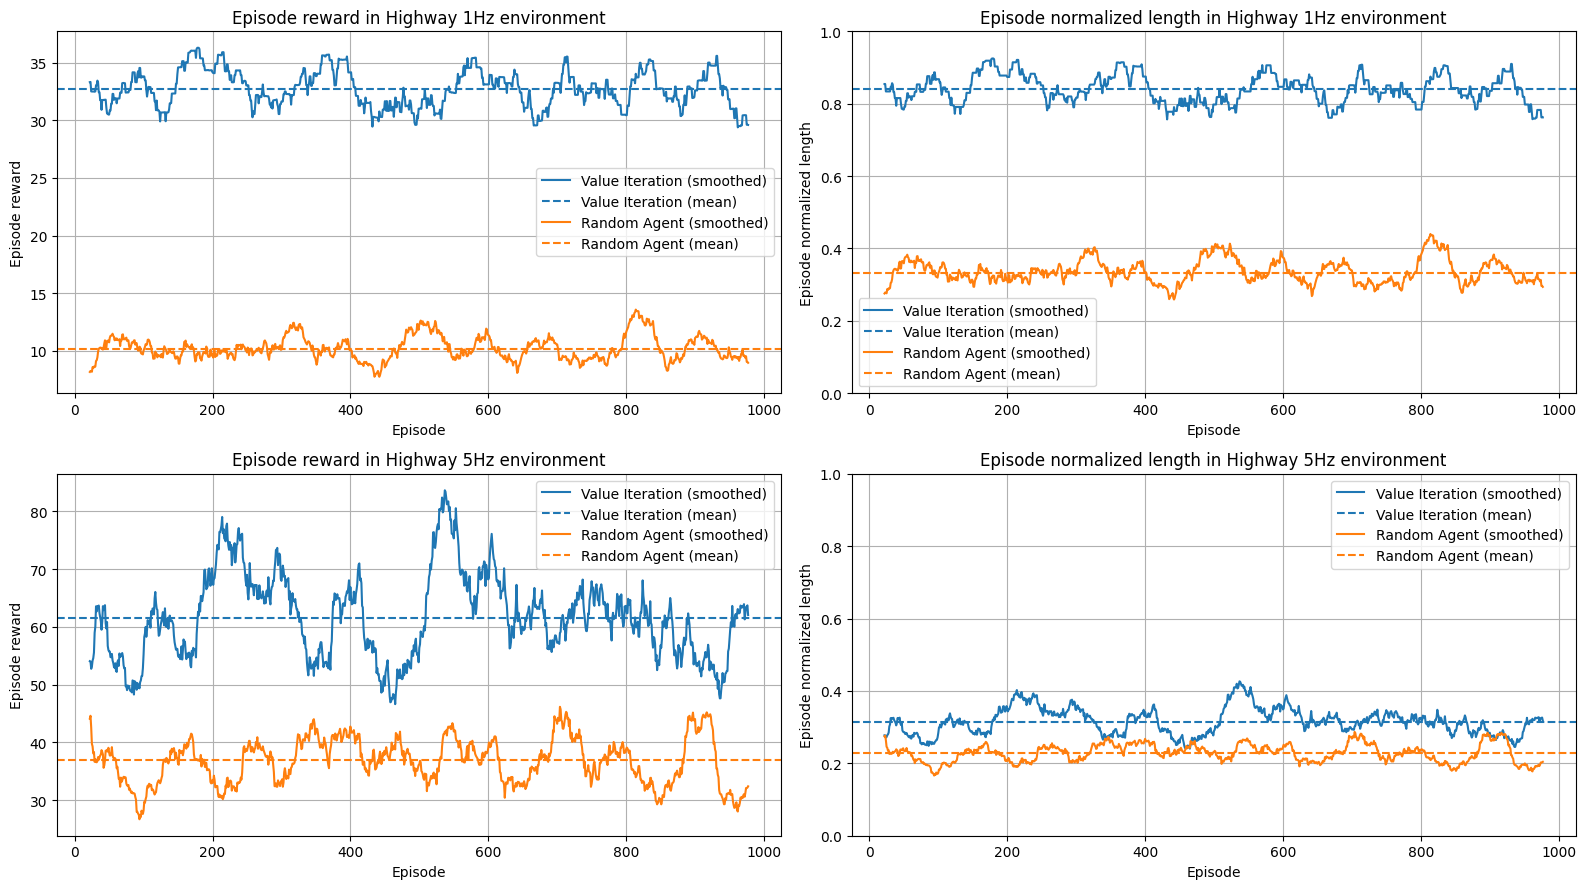

<p align="center">Fig. 5 - Value Iteration Agent and Random Agent metrics in both environments.</p>

The Figure 3 shows, that the Value Iteration agent fails at high policy frequency. This happens, as the higher frequency makes the environment more complex and the MDP approximation less accurate. In particular, the agent does not considers the vehicles sizes and cahneg lines too early or too late, causing the collsions. This does not occures in the 1Hz environment, as the minimal time between the actions is enough to distant the vehicles.

![inference](results\reinforce\inference.jpg)

<p align="center">Fig. 6 - Comparison of the agents' performances at validation.</p>

## Hyperparameter Optimization

The repository includes scripts for hyperparameter optimization using Optuna. 
To run the hyperparameter search, execute the scripts:
 - `hyperparameters_discrete.py` for the discrete action space
 - `hyperparameters_continuous.py` for the continuous action space

Results are saved as CSV files in the `./results/reinforce` folder.

Example command:
```bash
python hyperparameters_discrete.py
python hyperparameters_continuous.py
```